# **Assignment 9 - Adversarial Attacks**




Ana Araújo nº 59457\
Pedro Almeida nº 58844


In the following problem, we will be exploring an adversarial attack method for images called Fast Gradient Sign Method (FGSM), proposed in Goodfellow et al, 2014 and following this tutorial:https://www.tensorflow.org/
tutorials/generative/adversarial_fgsm.

## Problem 1:

From ImageNetV2 Testset (https://www.tensorflow.org/datasets/catalog/imagenet_v2), select an image to perform an adversarial attack on.
Based on your image and FGSM:

<br>

i) Calculate the gradient ∇xJ(θ, x, y), where J is the cross-entropy loss function, x is the image, and y is the label associated with the image.

<br>

ii) Calculate the sign of the gradient and visualize the results.

<br>

iii) Visualize the original image after applying the signed gradient noise with different ϵ values (e.g. 0.007, 0.01, 0.1, ...).

<br>

iv) Use the model to predict the labels of the original image with the signed gradient noise applied with different ϵ values. How does the confidence change as ϵ grows? Are the predicted labels semantically similar to the original label?

<br>

v) Use the model to predict the sign gradient and comment on the results.

**Import libraries:**

In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds

Load the image:

In [ ]:
ds = tfds.load('imagenet_v2', split='test', as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/imagenet_v2/matched-frequency/3.0.0.incompleteOC5GPG/imagenet_v2-test.tfre…

Dataset imagenet_v2 downloaded and prepared to /root/tensorflow_datasets/imagenet_v2/matched-frequency/3.0.0. Subsequent calls will reuse this data.


Getting the labels:

In [ ]:
#get labels
labels_path = tf.keras.utils.get_file('ImageNetlabels.txt','http://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

10484/10484 [==============================] - 0s 0us/step


In [ ]:
np.argmax(imagenet_labels =='Chihuahua')

152

In [ ]:
# get the 10 images with the Chihuahua labels
Chihuahua = list(ds.filter(lambda x,y: y == 151))
# get the first image
Chihuahua = Chihuahua[1][0]

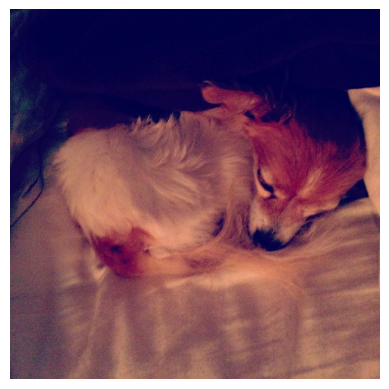

In [ ]:
plt.imshow(Chihuahua)
plt.axis('off')
plt.show()

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [ ]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [ ]:
image = Chihuahua
image = preprocess(image)
image_probs = pretrained_model.predict(image)

1/1 [==============================] - 1s 962ms/step


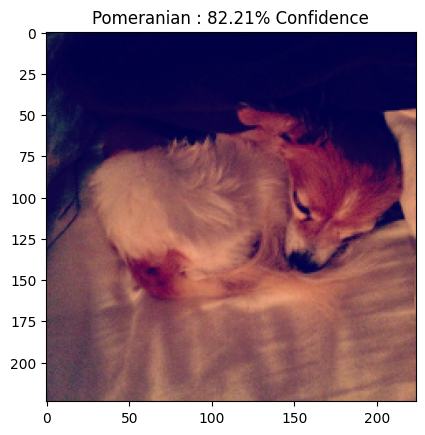

In [ ]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

process the image:

**i) and ii):**\
Calculation of the gradient and the sign of the gradient.

In [ ]:
# Define the loss function
loss_object = tf.keras.losses.CategoricalCrossentropy()


def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  print(gradient)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

tf.Tensor(
[[[[ 0.00028376  0.00188467  0.00012755]
   [-0.00369351 -0.00219277 -0.00145346]
   [-0.0015402   0.00613921  0.00169719]
   ...
   [-0.00489626 -0.01566106 -0.00596254]
   [-0.00060961 -0.00487699 -0.00463778]
   [ 0.01844452  0.02308383  0.00572559]]

  [[ 0.00326347  0.0074029   0.0014287 ]
   [ 0.00096238  0.0059799   0.00029024]
   [-0.00584582  0.01195462  0.00403653]
   ...
   [-0.00954022 -0.02726314 -0.01292646]
   [-0.00695029 -0.02755995 -0.01039032]
   [ 0.0196241   0.01317585  0.00747255]]

  [[-0.00034335  0.0007751  -0.00061217]
   [ 0.00585524  0.01752475  0.00314197]
   [-0.01471297 -0.0049167  -0.00148282]
   ...
   [-0.00087575 -0.00291147  0.00042682]
   [-0.00285675 -0.00262897 -0.00523669]
   [ 0.01757482  0.03211172  0.0056062 ]]

  ...

  [[-0.01168683 -0.00274843 -0.00149441]
   [-0.01238284 -0.00464274 -0.00091842]
   [-0.00013494 -0.01399122 -0.0058655 ]
   ...
   [ 0.00875779  0.01121665  0.00253015]
   [ 0.0193065   0.03169726  0.00876138]
   [-

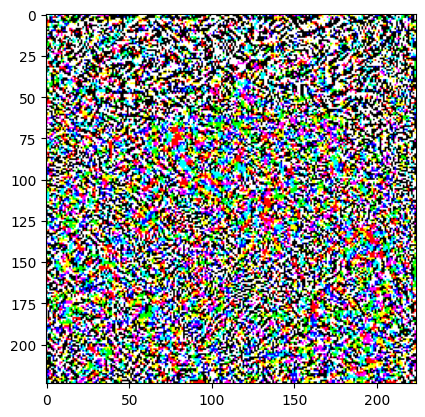

In [ ]:
# Get the input label of the image.
chihuahua_index = 152
label = tf.one_hot(chihuahua_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

**iii) and vi)**


In [ ]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(mld.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

1/1 [==============================] - 0s 129ms/step


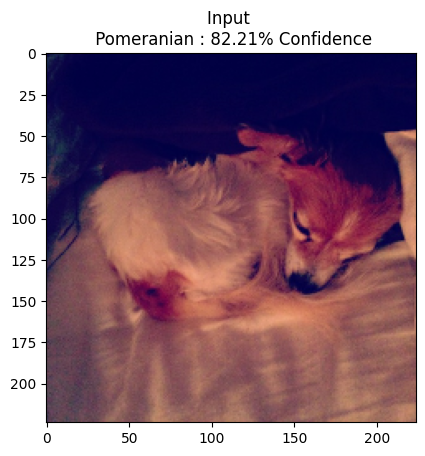

1/1 [==============================] - 0s 104ms/step


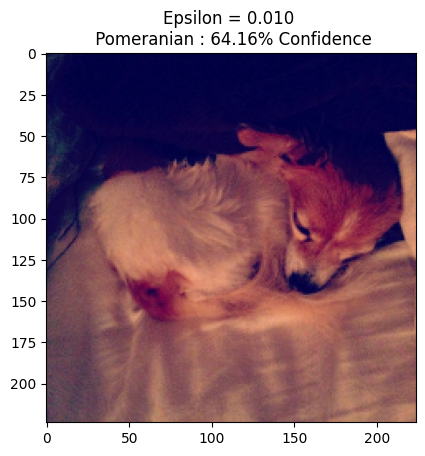

1/1 [==============================] - 0s 107ms/step


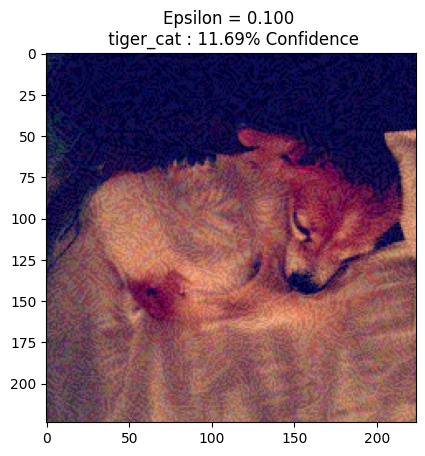

1/1 [==============================] - 0s 134ms/step


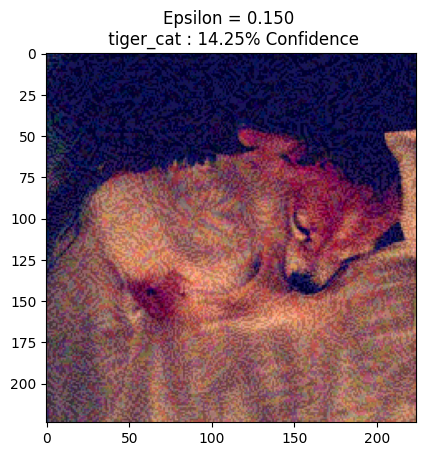

In [ ]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

It is simpler to deceive the network as epsilon grows. Nevertheless, the disturbances are easier to spot.

**v)**

In [ ]:
def predict_adversarial_pattern(input_image):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)

  # Get the gradients of the top predicted class w.r.t to the input image.
  top_class_index = tf.argmax(prediction[0])
  input_label = tf.one_hot(top_class_index, prediction.shape[-1])
  input_label = tf.reshape(input_label, (1, prediction.shape[-1]))
  gradient = tape.gradient(prediction, input_image)

  # Get the sign of the gradients
  signed_grad = tf.sign(gradient)
  print('signed gradient: ', signed_grad)
  return signed_grad

signed gradient:  tf.Tensor(
[[[[-1.  1. -1.]
   [-1. -1. -1.]
   [ 1.  1. -1.]
   ...
   [-1. -1. -1.]
   [-1. -1. -1.]
   [ 1.  1.  1.]]

  [[ 1.  1.  1.]
   [ 1.  1. -1.]
   [ 1.  1. -1.]
   ...
   [-1. -1. -1.]
   [-1. -1. -1.]
   [ 1.  1.  1.]]

  [[ 1.  1. -1.]
   [ 1.  1.  1.]
   [ 1. -1.  1.]
   ...
   [ 1.  1.  1.]
   [-1. -1. -1.]
   [ 1.  1.  1.]]

  ...

  [[-1.  1. -1.]
   [-1.  1. -1.]
   [-1. -1. -1.]
   ...
   [-1. -1. -1.]
   [ 1.  1.  1.]
   [-1. -1. -1.]]

  [[-1.  1.  1.]
   [-1. -1. -1.]
   [-1.  1.  1.]
   ...
   [ 1.  1. -1.]
   [-1.  1. -1.]
   [-1. -1. -1.]]

  [[ 1.  1.  1.]
   [-1. -1. -1.]
   [-1.  1.  1.]
   ...
   [ 1.  1.  1.]
   [ 1.  1.  1.]
   [ 1.  1. -1.]]]], shape=(1, 224, 224, 3), dtype=float32)


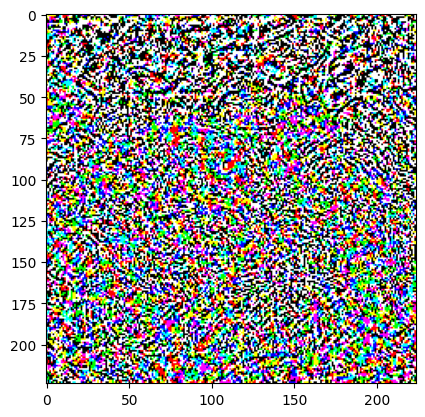

In [ ]:
# Get the sign of the gradients predicted by the model
predicted_grad = predict_adversarial_pattern(image)
plt.imshow(predicted_grad[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

The result is an image that shows the predicted sign of the gradient for each pixel. The sign gradient shows which direction each pixel should be changed to increase the model's confidence in the predicted class.